# Starbucks Capstone Challenge

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Examining datasets

### 1) Portfolio

Portfolio has the data about offers sent to customers. In this case there are 10 different offers.

**portfolio.json**

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


## 2) Profile

Profile table contains information of the customers.

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


One strange detail quickly drew my attention - there were multiple customers with age of 118. With more inspection seems like it is just a placeholder for null value, since seems like gender and income are nulls as well.

These kind of customers are probably not sharing their personal information.

In [6]:
profile[profile['age']==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [7]:
profile[profile['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

### Visualizing customer data

We could visualize the customer distribution a bit.

#### Age and gender

Text(0,0.5,'Number')

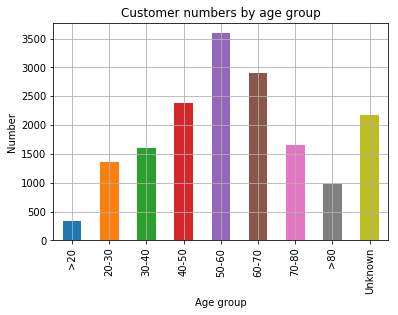

In [8]:
# Separate ages to age groups to make the data easier to view
def set_age_groups(data):   
    data['age'] = data.age.fillna(118)
    bins = (0, 20, 30, 40, 50, 60, 70, 80, 117, 120)
    edges = ['>20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '>80', 'Unknown']
    categories = pd.cut(data.age, bins, labels=edges)
    data['age'] = categories
    return data['age']
    
set_age_groups(profile)

ages = profile.groupby(['age']).size().plot(
                                        kind='bar',
                                        stacked=False, 
                                        grid=True, 
                                        title='Customer numbers by age group')
ages.set_xlabel("Age group")
ages.set_ylabel("Number")

Text(0,0.5,'Number')

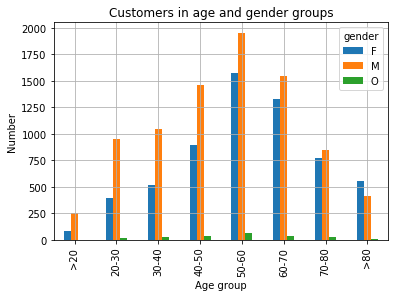

In [9]:
# Draw a bar chart of data excluding unknown
age_and_gender = profile.groupby(['age','gender']).size().unstack().plot(
                                                kind='bar',
                                                stacked=False, 
                                                grid=True, 
                                                title='Customers in age and gender groups')
age_and_gender.set_xlabel("Age group")
age_and_gender.set_ylabel("Number")

The gender column has a lot of nulls. If replaced with 'unknown' we can visualize how tall the bar is compared to other genders (female, male, other).

Text(0,0.5,'Number')

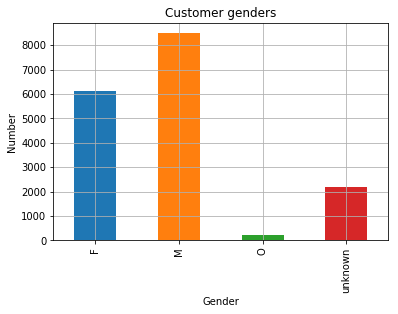

In [10]:
profile['gender'].fillna('unknown', inplace=True)
genders = profile.groupby(['gender']).size().plot(
                                    kind='bar',
                                    stacked=False, 
                                    grid=True, 
                                    title='Customer genders')
genders.set_xlabel("Gender")
genders.set_ylabel("Number")

#### Income

In [22]:
# Separate incomes to income groups to make the data easier to view
def set_income_groups(data):   
    data['income'] = data.income.fillna(-1)
    bins = (-2, 0, 45000, 60000, 75000, 90000, 120000)
    edges = ['secret', '<45000', '45001-60000', '60001-75000', '75001-90000', '>90001']
    categories = pd.cut(data.income, bins, labels=edges)
    data['income'] = categories
    return data
    
profile = set_income_groups(profile)

Text(0,0.5,'Number of customers')

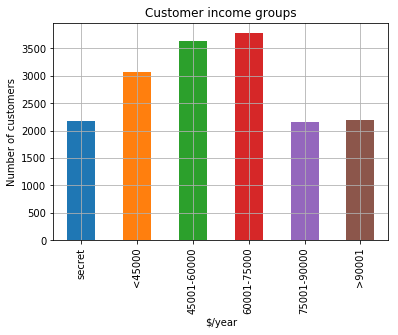

In [23]:
income_groups = profile.groupby(['income']).size().plot(
                                        kind='bar',
                                        stacked=False, 
                                        grid=True,
                                        title='Customer income groups')
income_groups.set_xlabel('$/year')
income_groups.set_ylabel('Number of customers')

Text(17.2,0.5,'Number of customers')

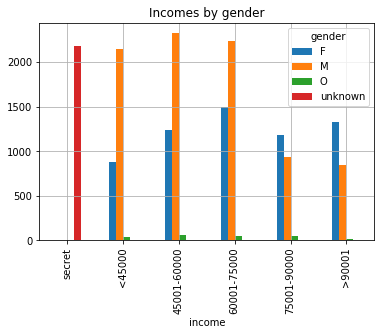

In [24]:
income_gender = profile.groupby(['income', 'gender']).size().unstack().plot(
                                        kind='bar',
                                        stacked=False, 
                                        grid=True,
                                        title='Incomes by gender')
income_groups.set_xlabel('$/year')
income_groups.set_ylabel('Number of customers')

Text(17.2,0.5,'Number of customers')

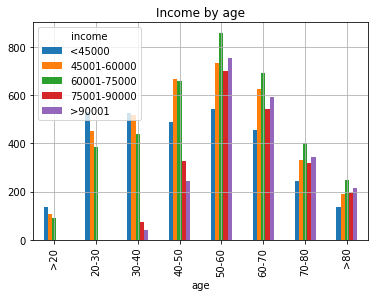

In [26]:
income_age = profile[profile['income']!='secret'].groupby(['age', 'income']).size().unstack().plot(
                                        kind='bar',
                                        stacked=False, 
                                        grid=True,
                                        title='Income by age')
income_groups.set_xlabel('$/year')
income_groups.set_ylabel('Number of customers')

## 3) Transcript

From this table you can find events connected to customers and offers. The value column contains some relevant info (offer id, amount and/of reward) in a dictionary.

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [11]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [12]:
transcript.tail()

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [13]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB





## More in-depth data exploration with one person

To better understand the connections within the datasets I am investigating one random person more closely.

In [14]:
# Example persons
# Offers completed before viewing - 9dc1421481194dcd9400aec7c9ae6366
# Several offers completed with one transaction - 389bc3fa690240e798340f5a15918d5c

In [15]:
test_person = profile[profile['id']=='e4052622e5ba45a8b96b59aba68cf068']
test_person

,age,became_member_on,gender,id,income
16999,60-70,20170722,F,e4052622e5ba45a8b96b59aba68cf068,82000.0


These are the actions the customer has performed during the time the data was collected.

In [16]:
test_person_actions = transcript[transcript['person']==test_person.iloc[0]['id']]
# dropping unnecessary person id column
test_person_actions = test_person_actions.drop(['person'], axis=1)
# resetting indexes to make the table easier to read
test_person_actions.reset_index(drop=True, inplace=True)

test_person_actions.head(10)

,event,time,value
0,offer received,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
1,offer viewed,6,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
2,transaction,54,{'amount': 21.55}
3,offer completed,54,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
4,transaction,84,{'amount': 25.19}
5,transaction,96,{'amount': 21.53}
6,offer received,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
7,offer received,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
8,transaction,480,{'amount': 30.57}
9,offer completed,480,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...


To make the data better to understand let's open the value column to separate columns.

In [17]:
person_actions_opened = pd.concat([test_person_actions.drop(['value'], axis=1), test_person_actions['value'].apply(pd.Series)], axis=1)

# It seems there might be offer ids in two columns, 'offer id' and 'offer_id'. 
## Combining those if that's the case.
def combine_offer_id_cols(data):
    if 'offer_id' in data.columns:
        data['offer id'] = data['offer id'].fillna(data['offer_id'])
        person_actions_opened.drop(['offer_id'], inplace=True, axis=1)
    return data

combine_offer_id_cols(person_actions_opened)

person_actions_opened

,event,time,offer id,amount,reward
0,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
1,offer viewed,6,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
2,transaction,54,NaN,21.55,NaN
3,offer completed,54,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0
4,transaction,84,NaN,25.19,NaN
5,transaction,96,NaN,21.53,NaN
6,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN
7,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
8,transaction,480,NaN,30.57,NaN
9,offer completed,480,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0


Since there seems to be offer completions before the offer has been viewed I am removing the irrelevant 'offer viewed' rows. Those do not matter when considering if an offer had any effect on a customer. The transaction rows are also irrelevant for now.

In [18]:
def remove_offer_viewed_if_after_completion(data):
    data = data[data['offer id'].notna()]
    offer_ids = data['offer id'].unique()
    
    for _id in offer_ids:
        rows = data[data['offer id'] == _id] # this also drops all transactions
        viewed_time = rows[rows['event']=='offer viewed']['time']        
        completed_time = rows[rows['event']=='offer completed']['time']

        if len(viewed_time.values)>0 and viewed_time.values[0] > completed_time.values[0]:
            row_to_drop = rows[rows['event']=='offer viewed'].index.values.astype(int)[0]
            print(row_to_drop)
            data = data.drop([row_to_drop])
    
    return data        

person_actions_actual = remove_offer_viewed_if_after_completion(person_actions_opened)
person_actions_actual

11


,event,time,offer id,amount,reward
0,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
1,offer viewed,6,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
3,offer completed,54,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0
6,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN
7,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
9,offer completed,480,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
12,offer received,576,3f207df678b143eea3cee63160fa8bed,NaN,NaN


One person can get the same offer more than once. We can also see how the customer has reacted to offers.

In [19]:
# group by with offer ids and one-hot-encoded events

test_person_offer_events = pd.concat([person_actions_actual, 
                                      pd.get_dummies(person_actions_actual['event'], 
                                      prefix=None)], 
                                      axis=1)
test_person_offer_events.drop(['event', 'time', ], axis=1, inplace=True)

aggregation_functions = {
    'offer completed': 'sum', 
    'offer received': 'sum', 
    'offer viewed': 'sum',
    'amount': 'sum',
    'reward': 'sum'}

test_person_offer_events = test_person_offer_events.groupby(test_person_offer_events['offer id']).aggregate(aggregation_functions)
test_person_offer_events = test_person_offer_events[['offer received', 'offer viewed', 'offer completed', 'reward']]
test_person_offer_events.sort_values(by=['offer received', 'offer viewed', 'offer completed'], ascending=False)

,offer received,offer viewed,offer completed,reward
offer id,,,,
3f207df678b143eea3cee63160fa8bed,2,0,0,0.0
2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,3.0
f19421c1d4aa40978ebb69ca19b0e20d,1,0,1,5.0


**Significant observations:**

- One offer can have three statuses: received, viewed and completed. Logically, an offer cannot be viewed or completed before it is received. However, it can be completed without being viewed. In this case you could say the offer did not affect the customer.
- A customer can get the same offer several times. In any case, each of them would be good to be considered separate to get better results when evaluating how an offer affected customers.
- Transactions cannot be connected to offers and one transaction can complete multiple offers. Than means you cannot tell how much a customer spent when completing an offer.

**Other thoughts:**
- The age distribution seems peculiar. I was surprised to see the biggest age groups using the Starbucks mobile app are 50-60, 60-70 and 40-50 when customers on their 20's and 30's are not represented in these numbers that much.
- When examining the data it is good to keep in mind this is data from 17 000 customers collected in 30 (29,75) days.